In [1]:
# Import libraries
import geopandas as gpd
import numpy as np
from shapely.geometry import box
import rasterio
import os
from tqdm import tqdm
import numpy as np
import fiona
import pandas as pd 
from shapely.strtree import STRtree
from shapely.geometry import Point as SPoint

## Part I: Creating our Graph

#### File-Paths
Understanding shapefiles: [Link](https://www.geowgs84.com/post/understanding-shapefiles-a-deep-dive-into-shp-dbf-shx-and-prj)

- `.shp`: points, lines and polygons; encoded in binary, ebgin with a fixed-length header and each feature then has its own header and content.
- `.shx`: spatial indexing - acts as an index for the `.shp` file - speeds up queries. Has fixed length records pointing to corresponding feature locations     
- `.prj`: projection file - contains the coordinate system and projection of our shapes
- `.dbf`: databased file - contains attribute data per shape - columns like name, population, elevation and the like.

Alternatives we may see: 
- GeoJSON 
- GPKG - Geopackage

*GeoPandas can be used for all vector files. Rasterio for all raster images*


In [2]:
DATA_DIRECTORY = "data"
# Effis Fire Dataset - European Forest Fire Information System
# https://forest-fire.emergency.copernicus.eu/applications/data-and-services
FIRE_DATA_PATH = os.path.join(DATA_DIRECTORY, "fire_data/modis.ba.poly.shp")

# Several TIFFs with Wildfire Severity, once again from Effis
WILDFIRE_SEVERITY_DIR = os.path.join(DATA_DIRECTORY, "wildfire_severity")

# Natural Earth - public domain dataset of global geography
# Admin 0 – Countries dataset has country boundaries
# https://www.naturalearthdata.com/downloads/110m-cultural-vectors/
COUNTRY_BOUNDARY_PATH = os.path.join(DATA_DIRECTORY, "country_boundaries/ne_110m_admin_0_countries.shp")

# Hydro River Network Database
RIVERS_PATH = os.path.join(DATA_DIRECTORY, "rivers", "euhydro_tajo_v013.gdb")

In [3]:
# Coordinate reference system - defines how spatial data coordinates relate to the earth. Defines origin, units, orientation
coord_ref_sys = "EPSG:25829"

In [4]:
# Create a data_plots directory
DATA_PLOTS_DIRECTORY = 'data_plots'
os.makedirs(DATA_PLOTS_DIRECTORY, exist_ok=True)

# Create output directory for Portugal grid shapefile
OUTPUT_DIRECTORY = 'output'
os.makedirs(OUTPUT_DIRECTORY, exist_ok=True)

### Filter out to our target area: Portugal

In [8]:
# GeoPandas looks in the same directory for data files by default (.dbf, .shx, etc.)
fire_data = gpd.read_file(FIRE_DATA_PATH)
fire_data = fire_data.to_crs(coord_ref_sys) # reproject to our fixed CRS
fire_data = fire_data[fire_data["COUNTRY"] == "PT"]
# fire_data = fire_data.iloc[:100]
print(fire_data["FIREDATE"].nunique())

3575


In [9]:
fire_data.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,SCLEROPH,TRANSIT,OTHERNATLC,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry
1,888,2016-08-08 00:00:00,2022-01-26 11:57:54.973474,PT,Área Metropolitana do Porto,Covelo de Paivó e Janarde,26593,0.6020922706404734,0.2558892150222012,0.2220215247986746,0,56.893956498833234,38.661849928501404,3.2174305712350297,0.14675999096861542,0,9.843358251326316,FireSeason,"POLYGON ((579029.216 4521945.363, 579214.437 4..."
2,19,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Caçarilhe e Infesta,81,0,1.17647058823391,0,0,67.05882352933287,19.99999999997647,11.7647058823391,0,0,0,FireSeason,"POLYGON ((578855.391 4584283.038, 578615.845 4..."
5,859,2016-09-05 00:00:00,2022-01-26 11:57:54.973474,PT,Região de Leiria,Caranguejeira,348,78.57142857140612,3.428571428570449,0,0,17.99999999999486,0,0,0,0,0,FireSeason,"POLYGON ((525871.781 4401862.371, 526043.222 4..."
6,424,2016-08-22 00:00:00,2022-01-26 11:57:54.973474,PT,Beiras e Serra da Estrela,Teixeira,432,0,1.3824884792623542,0,0,10.599078341011383,83.64055299537243,4.377880184330789,0,0,38.26787498738594,FireSeason,"POLYGON ((606007.177 4457933.675, 606068.426 4..."
7,528,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Penamaior,71,0,0,0,0,99.99999999985714,0,0,0,0,0,FireSeason,"POLYGON ((548661.189 4572533.195, 548655.78 45..."


In [25]:
# Get a polygon of Portugal
world = gpd.read_file(COUNTRY_BOUNDARY_PATH)
portugal = world[world["NAME"] == "Portugal"]

# https://epsg.io/25829
# Reprojection of Portugal to our fixed CRS (specified above)
portugal_proj = portugal.to_crs(coord_ref_sys) # degrees -> meters
mainland = portugal_proj.iloc[portugal_proj.geometry.area.argmax()]
mainland_polygon = mainland.geometry

# Extract bordering box around Portugal
minx, miny, maxx, maxy = mainland_polygon.bounds
print(f"minx: {minx}, miny: {miny}, maxx: {maxx}, maxy: {maxy}")

minx: 454235.1439060115, miny: 4077542.239783567, maxx: 718319.3451133408, maxy: 4681179.434351782


In [26]:
# Reducing observation area to the northern area of Portugal (where the concentration of fires is higher)

height = maxy - miny
width = maxx - minx

cut_minx = minx
cut_miny = miny + (height / 2)
cut_maxx = maxx
cut_maxy = maxy - (height * 0.15)

minx, miny, maxx, maxy = cut_minx, cut_miny, cut_maxx, cut_maxy
print(f"New minx: {minx}, new miny: {miny}, new maxx: {maxx}, new maxy: {maxy}")

New minx: 454235.1439060115, new miny: 4379360.837067675, new maxx: 718319.3451133408, new maxy: 4590633.85516655


In [27]:
grid_size = 3000 # meters - discretization size of what one node is in our graph
x_coords = np.arange(minx, maxx, grid_size)
y_coords = np.arange(miny, maxy, grid_size)

In [28]:
# create grid
grid_squares = []
for x in x_coords:
    for y in y_coords:
        # this makes a full rectangle grid
        cell = box(x, y, x + grid_size, y + grid_size)
        # only add cells that are inside mainland portugal (leave out the sea)
        if mainland_polygon.contains(cell):
            grid_squares.append(cell)

grid = gpd.GeoDataFrame({"geometry": grid_squares}, crs=coord_ref_sys)
print(f"Num nodes = {len(grid_squares)}")
grid.head()
# each entry is lower-left, upper-left, upper-right, lower-right, lower-left points of each square

Num nodes = 3924


,geometry
0,"POLYGON ((484235.144 4379360.837, 484235.144 4..."
1,"POLYGON ((487235.144 4379360.837, 487235.144 4..."
2,"POLYGON ((487235.144 4382360.837, 487235.144 4..."
3,"POLYGON ((490235.144 4379360.837, 490235.144 4..."
4,"POLYGON ((490235.144 4382360.837, 490235.144 4..."


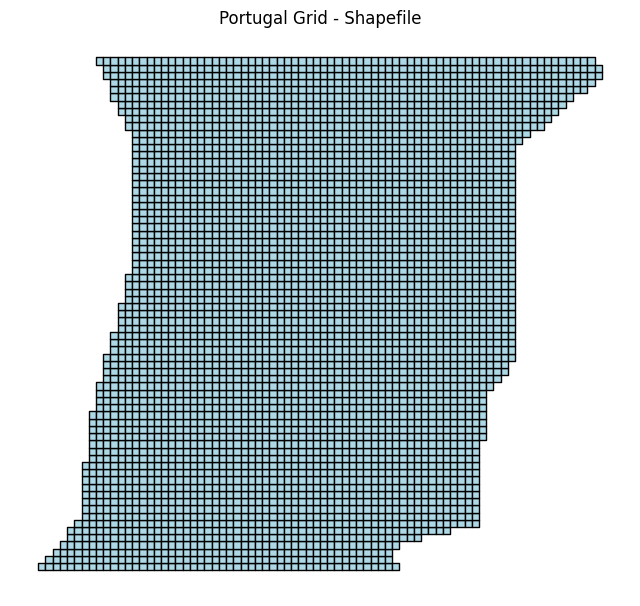

In [29]:
import matplotlib.pyplot as plt

# plot the observation area
fig, ax = plt.subplots(figsize=(8, 8))
grid.plot(ax=ax, edgecolor='black', facecolor='lightblue')
ax.ticklabel_format(style='sci', scilimits=(4,4))
ax.set_title("Portugal Grid - Shapefile")
ax.set_axis_off()
plt.savefig(os.path.join(DATA_PLOTS_DIRECTORY, "portugal_grid_plot.png"), dpi=300, bbox_inches="tight")
plt.show()

In [30]:
# saving observation area as shapefile and gpkg for better visualization in QGIS

grid.to_file(os.path.join(OUTPUT_DIRECTORY, "portugal_grid.shp"))
grid.to_file(os.path.join(OUTPUT_DIRECTORY,"portugal_grid.gpkg"), layer="grid", driver="GPKG")

In [55]:
# add columns for coordinates of grid squares' centers
grid_gdf = grid.copy()
#rename geometry to geometry grid
# grid_gdf = grid_gdf.rename(columns={'geometry': 'geometry_grid'})
grid_gdf["centroid_grid"] = grid.geometry.centroid
# grid_gdf["centroid_x_grid"] = grid.geometry.centroid.x
# grid_gdf["centroid_y_grid"] = grid.geometry.centroid.y
grid_gdf.head()

,geometry,centroid_grid
0,"POLYGON ((484235.144 4379360.837, 484235.144 4...",POINT (482735.144 4380860.837)
1,"POLYGON ((487235.144 4379360.837, 487235.144 4...",POINT (485735.144 4380860.837)
2,"POLYGON ((487235.144 4382360.837, 487235.144 4...",POINT (485735.144 4383860.837)
3,"POLYGON ((490235.144 4379360.837, 490235.144 4...",POINT (488735.144 4380860.837)
4,"POLYGON ((490235.144 4382360.837, 490235.144 4...",POINT (488735.144 4383860.837)


In [56]:
# add bodies of water information

# List of layer indices we need
layer_indices = [0, 1, 6, 8, 9]

# Read and concatenate all water layers
water_gdfs = []
for idx in layer_indices:
    layer_name = fiona.listlayers(RIVERS_PATH)[idx]
    gdf_layer = gpd.read_file(RIVERS_PATH, layer=layer_name)
    water_gdfs.append(gdf_layer)

# Combine all layers into a single GeoDataFrame
water_gdf = gpd.GeoDataFrame(pd.concat(water_gdfs, ignore_index=True))
print("Combined water bodies:", water_gdf.shape)

grid_gdf = grid_gdf.set_geometry('centroid_grid')

# Ensure the CRS matches the water layer
grid_gdf = grid_gdf.to_crs(water_gdf.crs)

water_gdf = water_gdf[water_gdf.geometry.notnull()]
water_geoms = water_gdf.geometry.values
water_tree = STRtree(water_gdf.geometry.values)

def nearest_water(point):
    if point is None or point.is_empty:
        return None
    # nearest() now returns index
    nearest_idx = water_tree.nearest(point)
    nearest_geom = water_geoms[nearest_idx]  # get the actual geometry
    return point.distance(nearest_geom)

grid_gdf['dist_to_water'] = grid_gdf.geometry.apply(nearest_water)
grid_gdf.to_crs(coord_ref_sys, inplace=True)
grid_gdf.head()


Combined water bodies: (41321, 52)


,geometry,centroid_grid,dist_to_water
0,"POLYGON ((484235.144 4379360.837, 484235.144 4...",POINT (482735.144 4380860.836),9366.776304
1,"POLYGON ((487235.144 4379360.837, 487235.144 4...",POINT (485735.144 4380860.836),7024.423788
2,"POLYGON ((487235.144 4382360.837, 487235.144 4...",POINT (485735.144 4383860.836),7587.118789
3,"POLYGON ((490235.144 4379360.837, 490235.144 4...",POINT (488735.144 4380860.836),4022.630401
4,"POLYGON ((490235.144 4382360.837, 490235.144 4...",POINT (488735.144 4383860.836),4895.181952


In [57]:
# TODO move this further down?
grid_gdf = grid_gdf.reset_index(drop=True)
grid_gdf["node_id"] = np.arange(len(grid_gdf))
grid_gdf.head()

,geometry,centroid_grid,dist_to_water,node_id
0,"POLYGON ((484235.144 4379360.837, 484235.144 4...",POINT (482735.144 4380860.836),9366.776304,0
1,"POLYGON ((487235.144 4379360.837, 487235.144 4...",POINT (485735.144 4380860.836),7024.423788,1
2,"POLYGON ((487235.144 4382360.837, 487235.144 4...",POINT (485735.144 4383860.836),7587.118789,2
3,"POLYGON ((490235.144 4379360.837, 490235.144 4...",POINT (488735.144 4380860.836),4022.630401,3
4,"POLYGON ((490235.144 4382360.837, 490235.144 4...",POINT (488735.144 4383860.836),4895.181952,4


#### Overlay with Fire Data

Assumption - if a grid square centroid overlaps with a fire point - the node corresponding to said grid square centroid is on fire. We want to make this into a series, per date, for each fire.

In [58]:
# fires_with_centroids["centroid_x"] = fire_data["GEOMETRY"]
# fire_data["centroid_x_fire"] = fire_data['geometry'].apply(lambda x: x.centroid.x)
# fire_data["centroid_y_fire"] = fire_data['geometry'].apply(lambda y: y.centroid.y)
fire_data["centroid_fire"] = fire_data['geometry'].apply(lambda y: y.centroid)
fire_data.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,...,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry,centroid_x_fire,centroid_y_fire,DAY,centroid_fire
1,888,2016-08-08 00:00:00,2022-01-26 11:57:54.973474,PT,Área Metropolitana do Porto,Covelo de Paivó e Janarde,26593,0.6020922706404734,0.2558892150222012,0.2220215247986746,...,3.2174305712350297,0.14675999096861542,0,9.843358251326316,FireSeason,"POLYGON ((579029.216 4521945.363, 579214.437 4...",569537.929816,4.526903e+06,2016-08-08,POINT (569537.93 4526902.766)
2,19,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Caçarilhe e Infesta,81,0,1.17647058823391,0,...,11.7647058823391,0,0,0,FireSeason,"POLYGON ((578855.391 4584283.038, 578615.845 4...",578340.742797,4.584768e+06,2016-08-11,POINT (578340.743 4584767.984)
5,859,2016-09-05 00:00:00,2022-01-26 11:57:54.973474,PT,Região de Leiria,Caranguejeira,348,78.57142857140612,3.428571428570449,0,...,0,0,0,0,FireSeason,"POLYGON ((525871.781 4401862.371, 526043.222 4...",526512.771879,4.401550e+06,2016-09-05,POINT (526512.772 4401549.956)
6,424,2016-08-22 00:00:00,2022-01-26 11:57:54.973474,PT,Beiras e Serra da Estrela,Teixeira,432,0,1.3824884792623542,0,...,4.377880184330789,0,0,38.26787498738594,FireSeason,"POLYGON ((606007.177 4457933.675, 606068.426 4...",606905.317296,4.457301e+06,2016-08-22,POINT (606905.317 4457301.419)
7,528,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Penamaior,71,0,0,0,...,0,0,0,0,FireSeason,"POLYGON ((548661.189 4572533.195, 548655.78 45...",549250.037391,4.572389e+06,2016-08-11,POINT (549250.037 4572389.254)


In [59]:
from datetime import datetime

fire_data["DAY"] = pd.to_datetime(fire_data["FIREDATE"], format='mixed').dt.date
# fire_data["FIREDATE"].nunique()
# fire_data["DAY"].nunique()

fire_data.head()

,id,FIREDATE,LASTUPDATE,COUNTRY,PROVINCE,COMMUNE,AREA_HA,BROADLEA,CONIFER,MIXED,...,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,geometry,centroid_x_fire,centroid_y_fire,DAY,centroid_fire
1,888,2016-08-08 00:00:00,2022-01-26 11:57:54.973474,PT,Área Metropolitana do Porto,Covelo de Paivó e Janarde,26593,0.6020922706404734,0.2558892150222012,0.2220215247986746,...,3.2174305712350297,0.14675999096861542,0,9.843358251326316,FireSeason,"POLYGON ((579029.216 4521945.363, 579214.437 4...",569537.929816,4.526903e+06,2016-08-08,POINT (569537.93 4526902.766)
2,19,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Caçarilhe e Infesta,81,0,1.17647058823391,0,...,11.7647058823391,0,0,0,FireSeason,"POLYGON ((578855.391 4584283.038, 578615.845 4...",578340.742797,4.584768e+06,2016-08-11,POINT (578340.743 4584767.984)
5,859,2016-09-05 00:00:00,2022-01-26 11:57:54.973474,PT,Região de Leiria,Caranguejeira,348,78.57142857140612,3.428571428570449,0,...,0,0,0,0,FireSeason,"POLYGON ((525871.781 4401862.371, 526043.222 4...",526512.771879,4.401550e+06,2016-09-05,POINT (526512.772 4401549.956)
6,424,2016-08-22 00:00:00,2022-01-26 11:57:54.973474,PT,Beiras e Serra da Estrela,Teixeira,432,0,1.3824884792623542,0,...,4.377880184330789,0,0,38.26787498738594,FireSeason,"POLYGON ((606007.177 4457933.675, 606068.426 4...",606905.317296,4.457301e+06,2016-08-22,POINT (606905.317 4457301.419)
7,528,2016-08-11 00:00:00,2022-01-26 11:57:54.973474,PT,Tâmega e Sousa,Penamaior,71,0,0,0,...,0,0,0,0,FireSeason,"POLYGON ((548661.189 4572533.195, 548655.78 45...",549250.037391,4.572389e+06,2016-08-11,POINT (549250.037 4572389.254)


In [60]:
# count the number of fires occurring per day
num_fires_by_day = fire_data.groupby("DAY").size().reset_index(name='fire_count')

print(num_fires_by_day.shape)
num_fires_by_day.head()

(1278, 2)


,DAY,fire_count
0,2016-05-01,2
1,2016-05-03,2
2,2016-05-04,1
3,2016-05-17,1
4,2016-06-04,1


In [61]:
def safe_stat(value, func="mean"):
    """Safely compute a statistic from a pandas Series, scalar, or missing value."""
    if value is None or isinstance(value, (float, int, np.generic, type(pd.NA))):
        return value if isinstance(value, (float, int)) else None
    
    try:
        if func == "mean":
            return value.mean()
        elif func == "sum":
            return value.sum()
        elif func == "mode":
            mode = value.mode()
            return mode.iloc[0] if not mode.empty else None
    except Exception:
        return None

### Clustering for weather data

In [98]:
from sklearn.cluster import KMeans

grid_gdf.to_crs(coord_ref_sys)
coords = np.array([(geom.y, geom.x) for geom in grid_gdf.centroid_grid])

# clustering based on geographic closeness
n_clusters = 50
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init = 10)
grid_gdf["cluster_id"] = kmeans.fit_predict(coords)

cluster_points = [SPoint(xy[1], xy[0]) for xy in kmeans.cluster_centers_]
# dict of the closest node to each cluster center
cluster_grid_centers = {}

for cluster_id, center in enumerate(cluster_points):
    cluster_nodes = grid_gdf[grid_gdf["cluster_id"] == cluster_id]
    # distances between the center of the cluster and all cluster nodes
    distances = cluster_nodes["centroid_grid"].distance(center)

    closest_node = distances.idxmin()
    closest_node_id = grid_gdf.loc[closest_node]["node_id"]
    closest_node_centroid = grid_gdf.loc[closest_node]["centroid_grid"]

    cluster_grid_centers[cluster_id] = (closest_node_id, closest_node_centroid)

cluster_grid_centers

{0: (np.int64(2641), <POINT (620735.144 4509860.836)>),
 1: (np.int64(178), <POINT (515735.144 4437860.836)>),
 2: (np.int64(586), <POINT (533735.144 4521860.836)>),
 3: (np.int64(1977), <POINT (593735.144 4434860.836)>),
 4: (np.int64(3208), <POINT (644735.144 4578860.836)>),
 5: (np.int64(1103), <POINT (554735.144 4581860.836)>),
 6: (np.int64(3563), <POINT (662735.144 4467860.836)>),
 7: (np.int64(2001), <POINT (593735.144 4506860.836)>),
 8: (np.int64(3634), <POINT (665735.144 4521860.836)>),
 9: (np.int64(1337), <POINT (566735.144 4431860.836)>),
 10: (np.int64(2160), <POINT (599735.144 4557860.836)>),
 11: (np.int64(1820), <POINT (587735.144 4389860.836)>),
 12: (np.int64(1850), <POINT (587735.144 4479860.836)>),
 13: (np.int64(131), <POINT (512735.144 4413860.836)>),
 14: (np.int64(506), <POINT (530735.144 4494860.836)>),
 15: (np.int64(3891), <POINT (695735.144 4581860.836)>),
 16: (np.int64(2530), <POINT (617735.144 4389860.836)>),
 17: (np.int64(954), <POINT (548735.144 45608

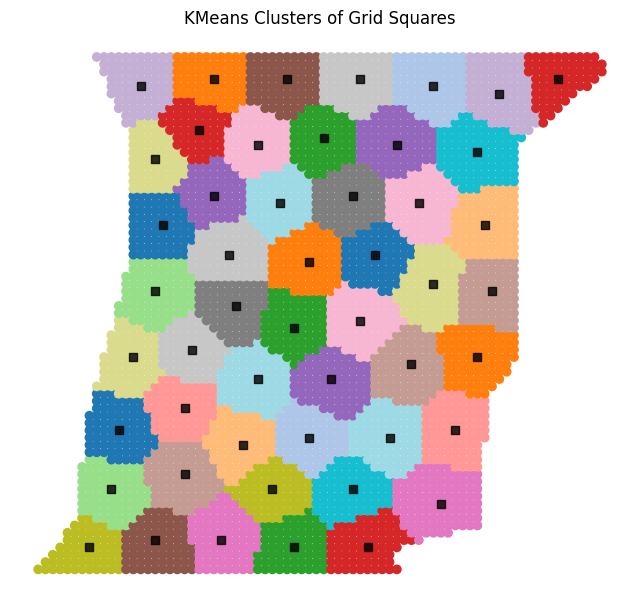

In [111]:
# visualize clusters
fig, ax = plt.subplots(figsize=(8, 8))
grid_gdf.plot(column="cluster_id", categorical=True, ax=ax, cmap="tab20")

center_points = [centroid for node_id, centroid in cluster_grid_centers.values()]

cluster_points = gpd.GeoDataFrame(
    geometry = center_points,
    crs = coord_ref_sys
)

cluster_points.plot(ax=ax, color="black",  alpha=0.8, marker="s")
ax.set_title("KMeans Clusters of Grid Squares")
ax.set_axis_off()
plt.savefig(os.path.join(DATA_PLOTS_DIRECTORY, "kmeans_weather.png"), dpi=300, bbox_inches="tight")
plt.show()

In [123]:
node_cluster = dict(zip(grid_gdf["centroid_grid"], grid_gdf["cluster_id"]))

def get_node_cluster_centroid(point):
    # Given a node's centroid, returns the cluster it is part of
    # Return None if not found
    print(f"Point {point}")

    cluster_id = node_cluster.get(point)
    if cluster_id is None:
        print(f"No cluster id")
        return None

    node_id, centroid = cluster_grid_centers.get(cluster_id, (None, None))
    return centroid

### Aggregate Grid Based on Day

# Important: This is currently set to break after one step

In [124]:
from meteostat import Point, Hourly
from datetime import timedelta
import pandas as pd
from tqdm import tqdm
import numpy as np

fire_data = fire_data.to_crs(grid_gdf.crs)
graphs = []
stop = 0
for day in tqdm(num_fires_by_day["DAY"]):
    stop = 1
    # get fire data for this day
    fire_data_day = fire_data[fire_data["DAY"] == day].copy()

    joined = gpd.sjoin(grid_gdf, fire_data_day, how="left", predicate="intersects")

    agg = (
        joined
        .assign(_hit = joined["index_right"].notna().astype(int))
        .groupby(level=0)  # group by grid cell index
        .agg(fire_count=("index_right", "count"),
             has_fire=("_hit", "max"))
    )

    # Merge back to geometry; fill missing (no matches) with zeros
    joined_one_row = grid_gdf.join(agg, how="left").fillna({"fire_count": 0, "has_fire": 0})
    joined_one_row["fire_count"] = joined_one_row["fire_count"].astype(int)
    joined_one_row["has_fire"]   = joined_one_row["has_fire"].astype(int)

    joined_one_row["node_id"] = grid_gdf["node_id"].values
    # normalize keeps only the date, resets time to midnight (00:00:00)
    joined_one_row["DAY"] = pd.to_datetime(day).normalize()

    coords = list(zip(joined.geometry.x, joined.geometry.y))

    # Note: this method does not handle an edge case where multiple fires occurred at the same place,
    joined["fire_intensity"] = 0
    for filename in os.listdir(WILDFIRE_SEVERITY_DIR):
        if filename.endswith(".tiff"):
            filepath = os.path.join(WILDFIRE_SEVERITY_DIR, filename)
            with rasterio.open(filepath) as src:
                # Ensure CRS match
                if joined.crs != src.crs:
                    joined = joined.to_crs(src.crs)
                    joined["centroid_grid"] = joined.geometry.centroid
                    coords = [(geom.x, geom.y) for geom in joined.centroid_grid]
                values = np.array([val[0] for val in src.sample(coords)])
                joined["fire_intensity"] = np.maximum(joined["fire_intensity"], values)
                # count = (joined_one_row["fire_intensity"] > 0).sum()
                # print(count)

    print(joined.columns)

    results = []
    i = 0
    for point, date in tqdm(zip(joined["centroid_grid"], joined["DAY"]), total=len(joined)):
        if point is None or pd.isna(date):
            continue

        # get corresponding cluster centroid
        cluster_center = get_node_cluster_centroid(point)

        if cluster_center == None:
            print("No cluster center found")
            break

        location = Point(cluster_center.y, cluster_center.x)

        # UTC timestamps for Meteostat
        start = pd.Timestamp(date)
        end = start + timedelta(days=1)

        # Fetch hourly data
        df = Hourly(location, start, end).fetch()
        if df.empty:
            i+=1

        if not df.empty:
            # Aggregate all hours in that day
            results.append({
                "DAY": date,
                "lat": point.y,
                "lon": point.x,
                "temp_mean": safe_stat(df["temp"], "mean"),
                "rhum_mean": safe_stat(df["rhum"], "mean"),
                "wdir_mean": safe_stat(df["wdir"], "mean"),
                "wspd_mean": safe_stat(df["wspd"], "mean"),
                "pres_mean": safe_stat(df["pres"], "mean"),
            })

    weather_df = pd.DataFrame(results)
    joined = pd.concat([joined, weather_df], axis=1)

    graphs.append(joined_one_row)

    if stop == 1:
        break

graphs[0].head()

  0%|          | 0/1278 [00:00<?, ?it/s]UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Index(['geometry', 'centroid_grid', 'dist_to_water', 'node_id', 'cluster_id',
       'index_right', 'id', 'FIREDATE', 'LASTUPDATE', 'COUNTRY', 'PROVINCE',
       'COMMUNE', 'AREA_HA', 'BROADLEA', 'CONIFER', 'MIXED', 'SCLEROPH',
       'TRANSIT', 'OTHERNATLC', 'AGRIAREAS', 'ARTIFSURF', 'OTHERLC',
       'PERCNA2K', 'CLASS', 'centroid_x_fire', 'centroid_y_fire', 'DAY',
       'centroid_fire', 'fire_intensity'],
      dtype='object')



  0%|          | 0/1278 [00:42<?, ?it/s]


,geometry,centroid_grid,dist_to_water,node_id,cluster_id,index_right,id,FIREDATE,LASTUPDATE,COUNTRY,...,AGRIAREAS,ARTIFSURF,OTHERLC,PERCNA2K,CLASS,centroid_x_fire,centroid_y_fire,DAY,centroid_fire,fire_intensity
0,"POLYGON ((484235.144 4379360.837, 484235.144 4...",POINT (-9.20103 39.57728),9366.776304,0,41,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0
1,"POLYGON ((487235.144 4379360.837, 487235.144 4...",POINT (-9.1661 39.57734),7024.423788,1,41,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0
2,"POLYGON ((487235.144 4382360.837, 487235.144 4...",POINT (-9.16616 39.60437),7587.118789,2,41,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0
3,"POLYGON ((490235.144 4379360.837, 490235.144 4...",POINT (-9.13116 39.57738),4022.630401,3,41,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0
4,"POLYGON ((490235.144 4382360.837, 490235.144 4...",POINT (-9.13122 39.60441),4895.181952,4,41,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,0


## Convert to .npy format with one feature (number of wildfires)

#### Make node order identical for timeseries_data and A

In [21]:
# Create a node index
node_index = (grid_gdf[["node_id"]]
              .drop_duplicates()
              .sort_values("node_id")
              .set_index("node_id")
              .index)

assert grid_gdf.crs and not grid_gdf.crs.is_geographic, "Grid must be in a projected CRS (meters)."

# Reorder grid_gdf to this canonical order so the distance matrix uses the same row order
grid_gdf = (grid_gdf
            .drop_duplicates(subset="node_id")
            .set_index("node_id")
            .loc[node_index]
            .reset_index())

assert grid_gdf["node_id"].is_unique, "node_id must be unique after dedup."

#### Distance Matrix

In [ ]:
cent = grid_gdf.geometry.centroid
N = len(cent)
A = np.zeros(shape = (N, N))

grid_points = grid_gdf["geometry"].to_numpy()
P1s = np.array(list(map(lambda x: np.array([x.centroid.x, x.centroid.y]), grid_points[:] )))
P2s = np.array(list(map(lambda x: np.array([x.centroid.x, x.centroid.y]), grid_points[:] )))

A = np.sum((P1s[:,None,:] - P2s[None,:,:])**2, axis=2)**0.5
np.fill_diagonal(A, 0.0)   # ensure exact zero self-distances

In [23]:
np.save("data/distance_matrix.npy", A)

In [24]:
# Sanity check to make sure the dist is in meters, not latitude
assert grid_gdf.crs and not grid_gdf.crs.is_geographic

#### Timeseries Data

In [25]:
# Construct Timeseries Data
# Concatenate all days into one long table (keep only what we need)
long = pd.concat(
    [
        g[["node_id", "fire_count", "DAY"]].copy()
          .assign(DAY=pd.to_datetime(g["DAY"]).dt.normalize())  # ensure consistent dtype
        for g in graphs
    ],
    axis=0,
    ignore_index=True
)

# If any duplicates slipped in per (node_id, DAY), sum them:
long = (long
        .groupby(["node_id", "DAY"], as_index=False)["fire_count"]
        .sum())

# Create sorted day index
day_index = (long["DAY"]
             .dropna()
             .sort_values()
             .unique())

#Pivot to wide matrix (N x T), fill missing vals with 0:
wide = (long
        .pivot_table(index="node_id", columns="DAY", values="fire_count", aggfunc="sum", fill_value=0)
        .reindex(index=node_index, columns=day_index, fill_value=0)
        .sort_index(axis=0)
        .sort_index(axis=1))

#Final (N,T) float32 array:
timeseries_data = wide.to_numpy(dtype=np.float32)  # shape (10041, 1284)

np.save("data/timeseries_data.npy", timeseries_data)
np.save("data/days.npy", day_index.astype("datetime64[ns]"))
# grid_gdf[["centroid_x_grid", "centroid_y_grid"]].describe()


In [26]:
# Final sanity checks for adjacency matrices
N = len(node_index)
assert A.shape == (N, N), "Distance matrix shape mismatch."
assert np.allclose(A, A.T), "Distance matrix must be symmetric."
assert timeseries_data.shape[0] == N, "Timeseries row count must match nodes."
assert np.isfinite(timeseries_data).all(), "Timeseries contains non-finite values."

## Clustering grid squares in terms of weather data to reduce number of API calls

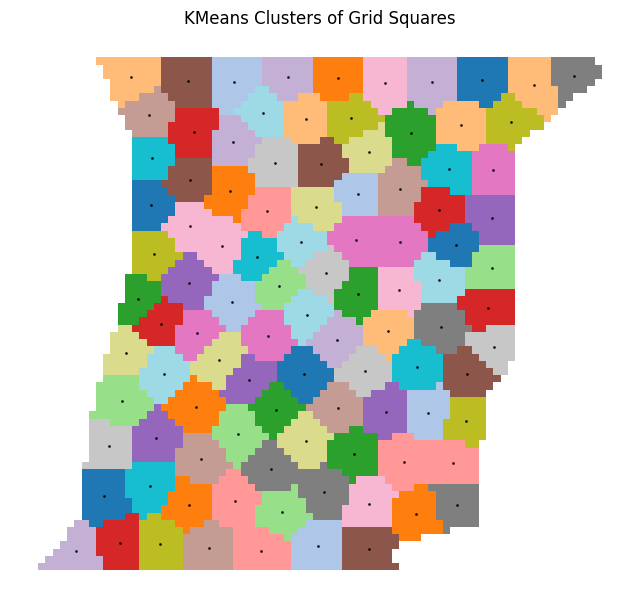

,node_id,geometry,centroid_grid,centroid_x_grid,centroid_y_grid,dist_to_water,cluster_id
0,0,"POLYGON ((484235.144 4379360.837, 484235.144 4...",POINT (482735.144 4380860.836),482735.143906,4.380861e+06,9366.776304,48
1,1,"POLYGON ((487235.144 4379360.837, 487235.144 4...",POINT (485735.144 4380860.836),485735.143906,4.380861e+06,7024.423788,48
2,2,"POLYGON ((487235.144 4382360.837, 487235.144 4...",POINT (485735.144 4383860.836),485735.143906,4.383861e+06,7587.118789,48
3,3,"POLYGON ((490235.144 4379360.837, 490235.144 4...",POINT (488735.144 4380860.836),488735.143906,4.380861e+06,4022.630401,48
4,4,"POLYGON ((490235.144 4382360.837, 490235.144 4...",POINT (488735.144 4383860.836),488735.143906,4.383861e+06,4895.181952,48


In [27]:
from sklearn.cluster import KMeans

grid_gdf.to_crs(coord_ref_sys)
coords = np.array([(geom.y, geom.x) for geom in grid_gdf.centroid_grid])

# clustering based on geographic closeness
n_clusters = 100
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init = 10)
grid_gdf["cluster_id"] = kmeans.fit_predict(coords)

fig, ax = plt.subplots(figsize=(8, 8))
grid_gdf.plot(column="cluster_id", categorical=True, ax=ax, cmap="tab20")

cluster_centers = kmeans.cluster_centers_
cluster_points = gpd.GeoDataFrame(
    geometry = [SPoint(xy[1], xy[0]) for xy in cluster_centers],
    crs = coord_ref_sys
)

cluster_points.plot(ax=ax, color="black", markersize=1, alpha=0.8)
ax.set_title("KMeans Clusters of Grid Squares")
ax.set_axis_off()
plt.savefig(os.path.join(DATA_PLOTS_DIRECTORY, "kmeans_weather.png"), dpi=300, bbox_inches="tight")
plt.show()

grid_gdf.head()

In [28]:
from meteostat import Point, Hourly
from datetime import timedelta

start = pd.Timestamp(fire_data["DAY"].min())
end = pd.Timestamp(fire_data["DAY"].max() + timedelta(days=1))

cluster_weather = []

for cluster_id, group in grid_gdf.groupby("cluster_id"):
    # Fetch weather data for each cluster (instead of every grid square)
    lat = group.geometry.centroid.y.mean()
    lon = group.geometry.centroid.x.mean()

    # fetch weather data for the full date range
    df_weather = Hourly(Point(lat, lon), start, end).fetch()

    if not df_weather.empty:
        daily = df_weather.resample("D").mean().reset_index() # daily mean
        daily["DAY"] = daily["time"].dt.date
        daily["cluster_id"] = cluster_id
        # temperature, relative humidity, wind direction, wind speed, air pressure
        cluster_weather.append(daily[["cluster_id", "DAY", "temp", "rhum", "wdir", "wspd", "pres"]])

weather_df = pd.concat(cluster_weather, ignore_index=True)
weather_df.to_csv(os.path.join(DATA_PLOTS_DIRECTORY, "cluster_weather.csv"), index=False)

weather_df.head()

,cluster_id,DAY,temp,rhum,wdir,wspd,pres
0,0,2019-11-04,5.566667,78.666667,13.5,1.2,1033.766667
1,0,2019-11-05,5.65,63.416667,68.625,5.620833,1031.7375
2,0,2019-11-06,6.245833,50.0,94.875,5.3,1026.654167
3,0,2019-11-07,8.670833,42.416667,87.958333,4.679167,1024.075
4,0,2019-11-08,8.558333,49.166667,64.73913,3.825,1026.475


### Original Fire Attributes
- **`id`** → Unique identifier for each fire record.  
- **`FIREDATE`** → Date and time when the fire occurred.  
- **`LASTUPDATE`** → Timestamp of the last update for the fire record.  
- **`COUNTRY`** → Country where the fire occurred.  
- **`PROVINCE`** → Province of the fire location.  
- **`COMMUNE`** → Commune (local administrative area) of the fire.  
- **`AREA_HA`** → Burned area in hectares.  

### Land Cover / Fire Area Composition
- **`BROADLEA`** → Proportion of broadleaf vegetation in the fire area.  
- **`CONIFER`** → Proportion of coniferous vegetation.  
- **`MIXED`** → Proportion of mixed forest.  
- **`SCLEROPH`** → Proportion of sclerophyllous vegetation (e.g., Mediterranean shrubs).  
- **`TRANSIT`** → Proportion of transitional land cover.  
- **`OTHERNATLC`** → Proportion of other natural land cover.  
- **`AGRIAREAS`** → Proportion of agricultural areas.  
- **`ARTIFSURF`** → Proportion of artificial surfaces (urban/industrial).  
- **`OTHERLC`** → Proportion of other land cover types.  
- **`PERCNA2K`** → Percentage of area under special designation (e.g., Natura 2000).  
- **`CLASS`** → Fire classification or severity category.  

### Fire Geometry / Location
- **`geometry`** → Original fire geometry (polygon or point).  
- **`centroid_x_fire`** → X coordinate of fire centroid.  
- **`centroid_y_fire`** → Y coordinate of fire centroid.  

### Spatial Join with Grid Cells
- **`index_right`** → Index of the grid cell containing the fire centroid (NaN if none).  
- **`centroid_grid`** → Geometry of the grid cell centroid.  
- **`centroid_x_grid`** → X coordinate of the grid cell centroid.  
- **`centroid_y_grid`** → Y coordinate of the grid cell centroid.  
- **`has_fire`** → Boolean indicating if the fire is inside a grid cell.  

### Time-Based Helper
- **`DAY`** → Date only (no time), extracted from `FIREDATE`, used for grouping fires by day.


In [29]:
# A summary and sample of the graphs list - + persistence
import pickle
with open('output/graphs.pkl', 'wb') as f:
    pickle.dump(graphs, f)
    
print("Number of time steps(graphs)", len(graphs))
print("Example graph for one day:")
graphs[0]

Number of time steps(graphs) 1278
Example graph for one day:


,geometry,centroid_grid,centroid_x_grid,centroid_y_grid,dist_to_water,node_id,fire_count,has_fire,DAY
0,"POLYGON ((484235.144 4379360.837, 484235.144 4...",POINT (482735.144 4380860.836),482735.143906,4.380861e+06,9366.776304,0,0,0,2016-05-01
1,"POLYGON ((487235.144 4379360.837, 487235.144 4...",POINT (485735.144 4380860.836),485735.143906,4.380861e+06,7024.423788,1,0,0,2016-05-01
2,"POLYGON ((487235.144 4382360.837, 487235.144 4...",POINT (485735.144 4383860.836),485735.143906,4.383861e+06,7587.118789,2,0,0,2016-05-01
3,"POLYGON ((490235.144 4379360.837, 490235.144 4...",POINT (488735.144 4380860.836),488735.143906,4.380861e+06,4022.630401,3,0,0,2016-05-01
4,"POLYGON ((490235.144 4382360.837, 490235.144 4...",POINT (488735.144 4383860.836),488735.143906,4.383861e+06,4895.181952,4,0,0,2016-05-01
...,...,...,...,...,...,...,...,...,...
3919,"POLYGON ((712235.144 4583360.837, 712235.144 4...",POINT (710735.144 4584860.836),710735.143906,4.584861e+06,91463.864312,3919,0,0,2016-05-01
3920,"POLYGON ((712235.144 4586360.837, 712235.144 4...",POINT (710735.144 4587860.836),710735.143906,4.587861e+06,93926.132309,3920,0,0,2016-05-01
3921,"POLYGON ((712235.144 4589360.837, 712235.144 4...",POINT (710735.144 4590860.836),710735.143906,4.590861e+06,96418.506215,3921,0,0,2016-05-01
3922,"POLYGON ((715235.144 4583360.837, 715235.144 4...",POINT (713735.144 4584860.836),713735.143906,4.584861e+06,89720.357593,3922,0,0,2016-05-01


## Attempt to Convert to .npy Format for the Models

In [30]:
# date_col = "FIREDATE"   # adjust to your real column name
# fire_data[date_col] = pd.to_datetime(fire_data[date_col]).dt.normalize()
# full_days = pd.date_range(
#     fire_data[date_col].min(),
#     fire_data[date_col].max(),
#     freq="D"
# )